In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

from panda.patchtst.pipeline import PatchTSTPipeline
from panda.utils import (
    apply_custom_style,
    get_system_filepaths,
    load_trajectory_from_arrow,
    make_clean_projection,
)

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Apply matplotlib style from config
apply_custom_style("../config/plotting.yaml")

In [4]:
# run_name = "pft_rff496_proj-0"
run_name = "pft_chattn_emb_w_poly-0"  # NOTE: this is still the best
# run_name = "pft_chattn_noembed_pretrained_correct-0"
pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path=f"/stor/work/AMDG_Gilpin_Summer2024/checkpoints/{run_name}/checkpoint-final",
    device_map="cuda:0",
)

In [5]:
pft_model.model.model.encoder.layers[0]

PatchTSTEncoderLayerWithRope(
  (temporal_self_attn): PatchTSTRopeAttention(
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (channel_self_attn): PatchTSTRopeAttention(
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout_path1): Identity()
  (norm_sublayer1): PatchTSTRMSNorm()
  (dropout_path2): Identity()
  (norm_sublayer2): PatchTSTRMSNorm()
  (ff): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELUActivation()
    (2): Identity()
    (3): Linear(in_features=512, out_features=512, bias=True)
  )

In [15]:
def plot_model_prediction(
    model,
    context: np.ndarray,
    groundtruth: np.ndarray,
    prediction_length: int,
    title: str | None = None,
    save_path: str | None = None,
    show_plot: bool = True,
    figsize: tuple[int, int] = (6, 8),
    **kwargs,
):
    context_tensor = torch.from_numpy(context.T).float().to(model.device)[None, ...]
    print(f"context_tensor shape: {context_tensor.shape}")
    pred = (
        model.predict(context_tensor, prediction_length, **kwargs)
        .squeeze()
        .cpu()
        .numpy()
    )
    total_length = context.shape[1] + prediction_length
    context_ts = np.arange(context.shape[1]) / total_length
    pred_ts = np.arange(context.shape[1], total_length) / total_length

    # Add the last time point of context to the beginning of groundtruth
    # This ensures continuity between context and groundtruth in the plot
    if context.shape[1] > 0 and groundtruth.shape[1] > 0:
        last_context_point = context[:, -1][
            :, np.newaxis
        ]  # Get last point and reshape to column vector
        groundtruth = np.hstack(
            (last_context_point, groundtruth)
        )  # Prepend to groundtruth

        # Prepend last context point to prediction timeline and data for continuity
        pred_ts = np.concatenate(([context_ts[-1]], pred_ts))
        if pred.shape[0] + 1 == len(pred_ts):
            pred = np.vstack((context[:, -1], pred))

    # Create figure with gridspec layout
    fig = plt.figure(figsize=figsize)

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(2, 1, height_ratios=[0.65, 0.35], hspace=-0.1)

    # Create sub-grid for the plots
    gs = outer_grid[1].subgridspec(3, 1, height_ratios=[0.2] * 3, wspace=0, hspace=0)
    ax_3d = fig.add_subplot(outer_grid[0], projection="3d")

    ax_3d.plot(*context[:3], alpha=0.5, color="black", label="Context")
    ax_3d.plot(*groundtruth[:3], linestyle="-", color="black", label="Groundtruth")
    ax_3d.plot(*pred.T[:3], color="red", label="Prediction")
    # make_arrow_axes(ax_3d)
    make_clean_projection(ax_3d)

    if title is not None:
        title_name = title.replace("_", " ")
        ax_3d.set_title(title_name, fontweight="bold")

    axes_1d = [fig.add_subplot(gs[i, 0]) for i in range(3)]
    for i, ax in enumerate(axes_1d):
        ax.plot(context_ts, context[i], alpha=0.5, color="black")
        ax.plot(pred_ts, groundtruth[i], linestyle="-", color="black")
        ax.plot(pred_ts, pred[:, i], color="red")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        print(f"saving fig to: {save_path}")
        plt.savefig(save_path, bbox_inches="tight")
    if show_plot:
        plt.show()
    plt.close()

In [16]:
split = "final_skew40"
test_data_dir = f"/stor/work/AMDG_Gilpin_Summer2024/data/improved/{split}"
subsplit = "test_zeroshot"

In [17]:
test_system_subdirs = os.listdir(os.path.join(test_data_dir, subsplit))
test_system_subdirs = [
    d
    for d in test_system_subdirs
    if os.path.isdir(os.path.join(test_data_dir, subsplit, d))
]
print(len(test_system_subdirs))

445


In [18]:
# select random 10 systems from test_system_subdirs
selected_pair_names = np.random.choice(test_system_subdirs, 5, replace=False)
print(selected_pair_names)

['NoseHoover_Bouali' 'QiChen_SprottK' 'ChenLee_HyperYangChen'
 'MacArthur_HyperCai' 'LorenzStenflo_IsothermalChemical']


In [19]:
# (sample_idx, start_time, prediction_length, subsample_interval) assuming context_length = 512
# choice of start_time=1024 is arbitrary, just to cut off transient if it happens to exist even after filtering
# choice of prediction_length=256 is also arbtirary, but make sure it is a multiple of 128, the prediction length we trained for
chosen_forecast_settings = {
    pair_name: (0, 1024, 256, 1) for pair_name in selected_pair_names
}

In [20]:
print(len(chosen_forecast_settings.keys()))

5


context_tensor shape: torch.Size([1, 512, 3])


/stor/home/ab75733/dystformer/panda/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


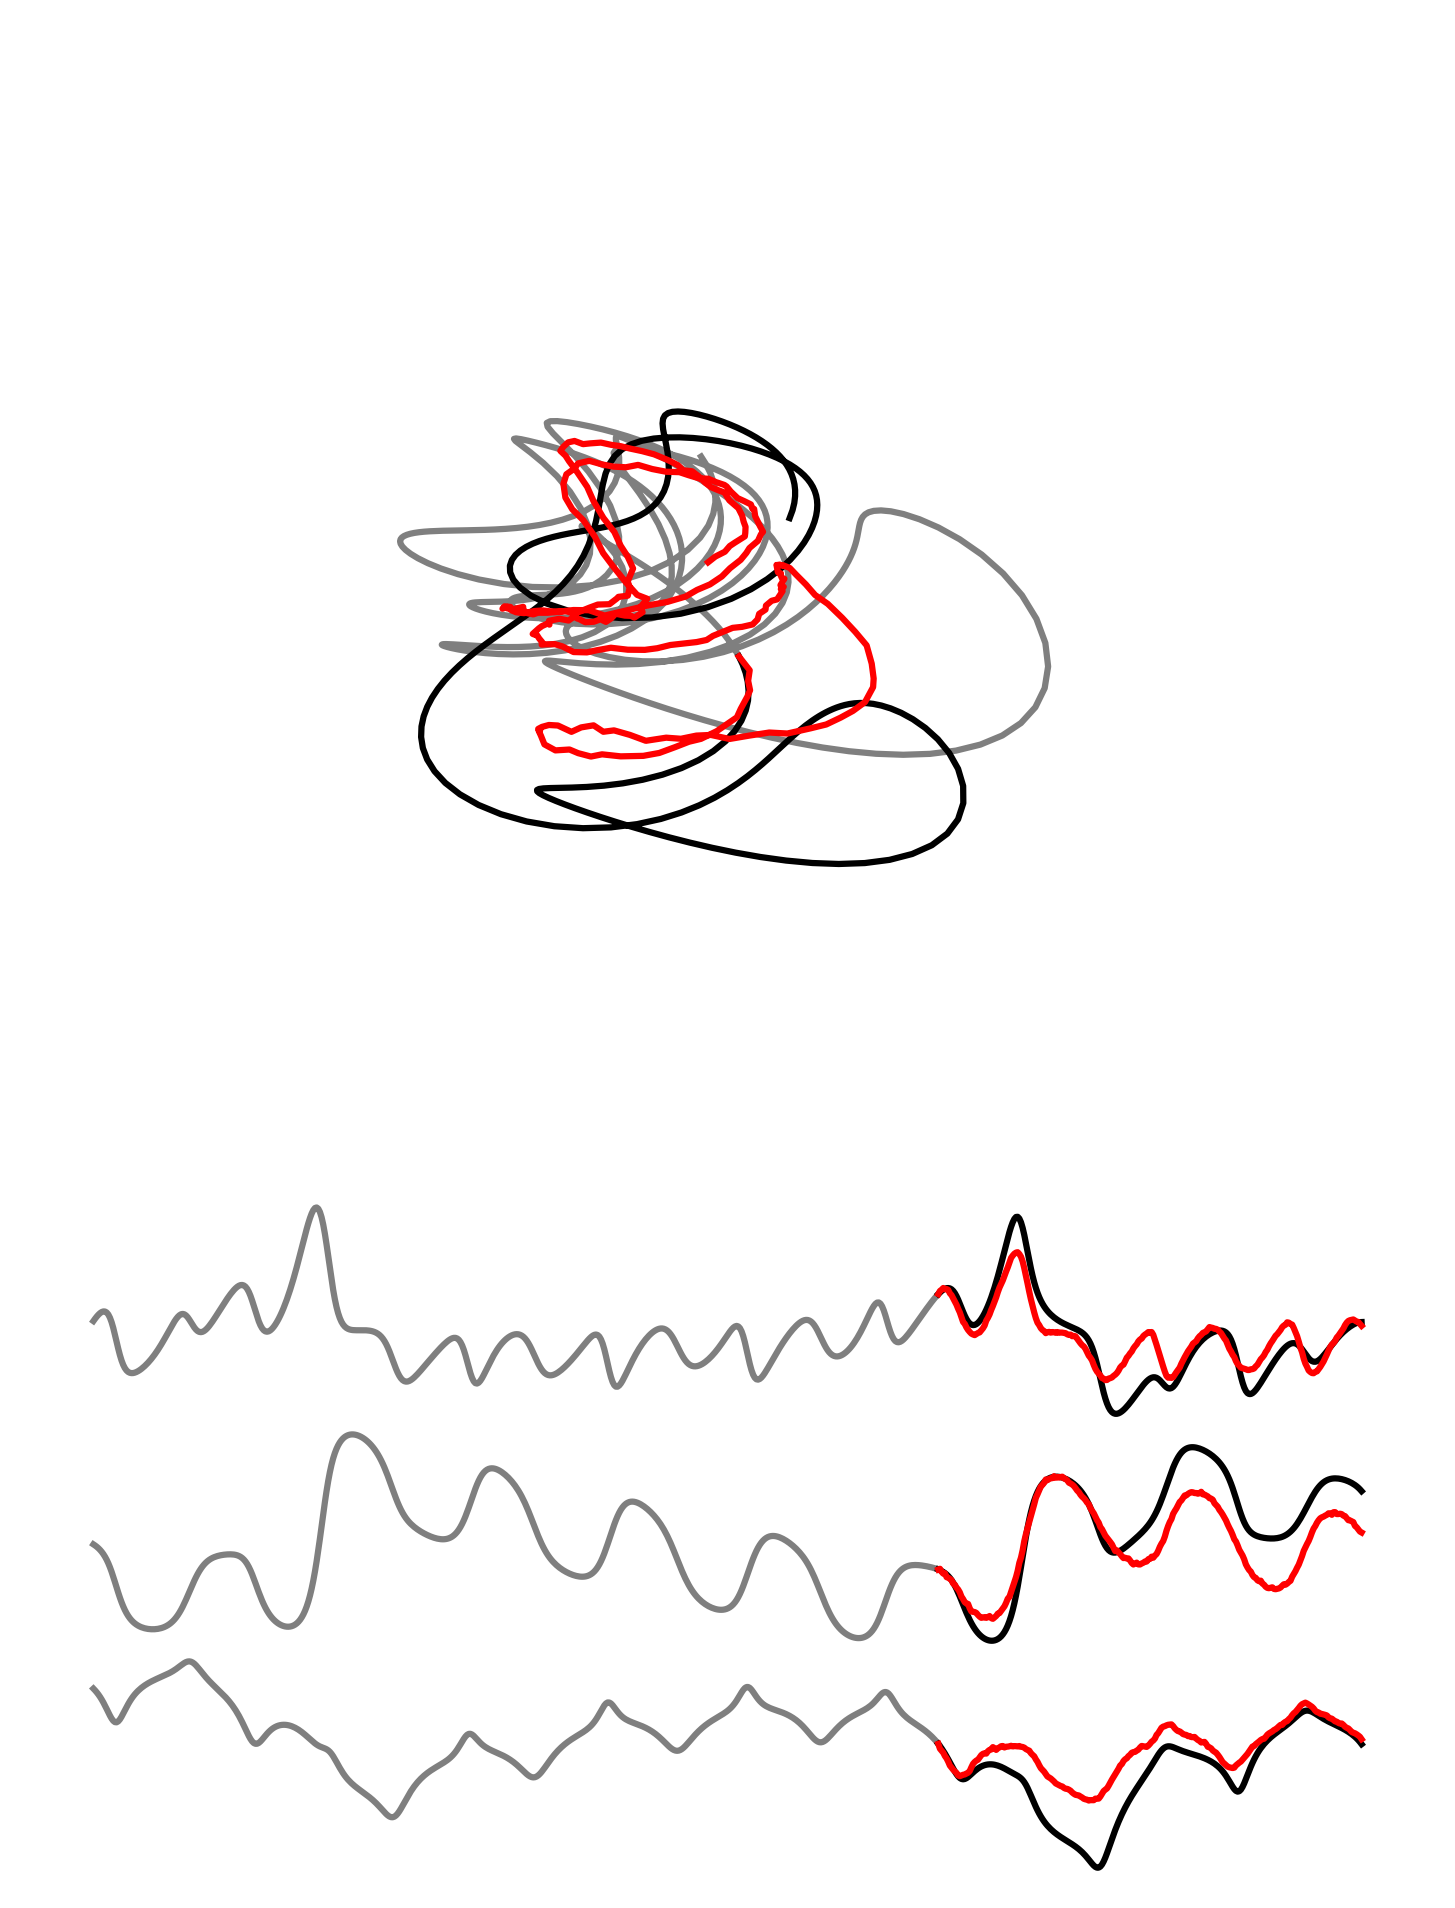

context_tensor shape: torch.Size([1, 512, 3])


/stor/home/ab75733/dystformer/panda/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


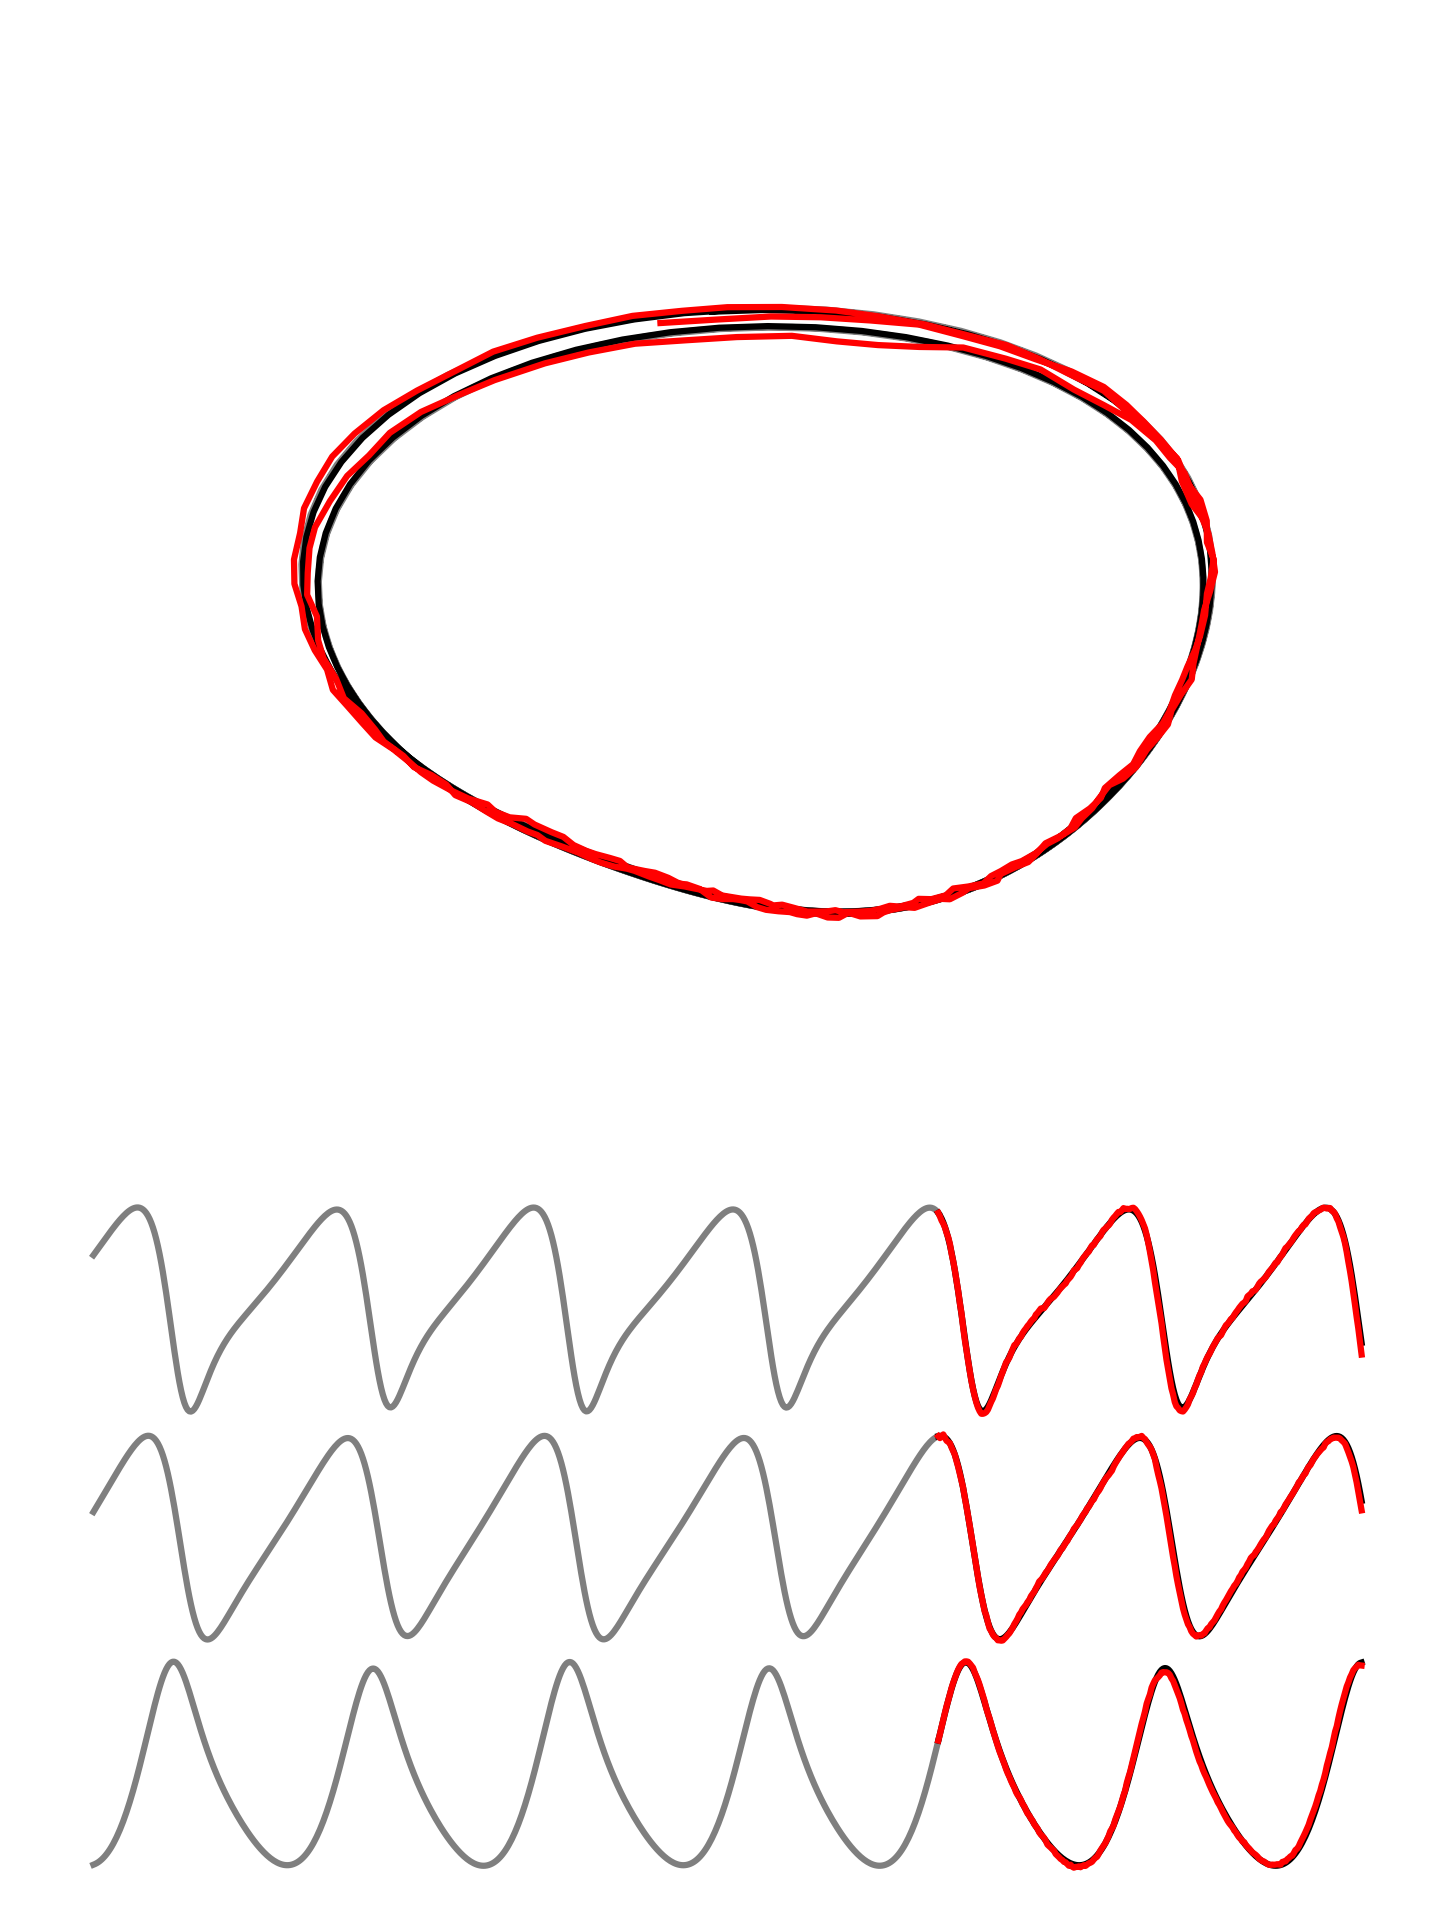

context_tensor shape: torch.Size([1, 512, 4])


/stor/home/ab75733/dystformer/panda/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


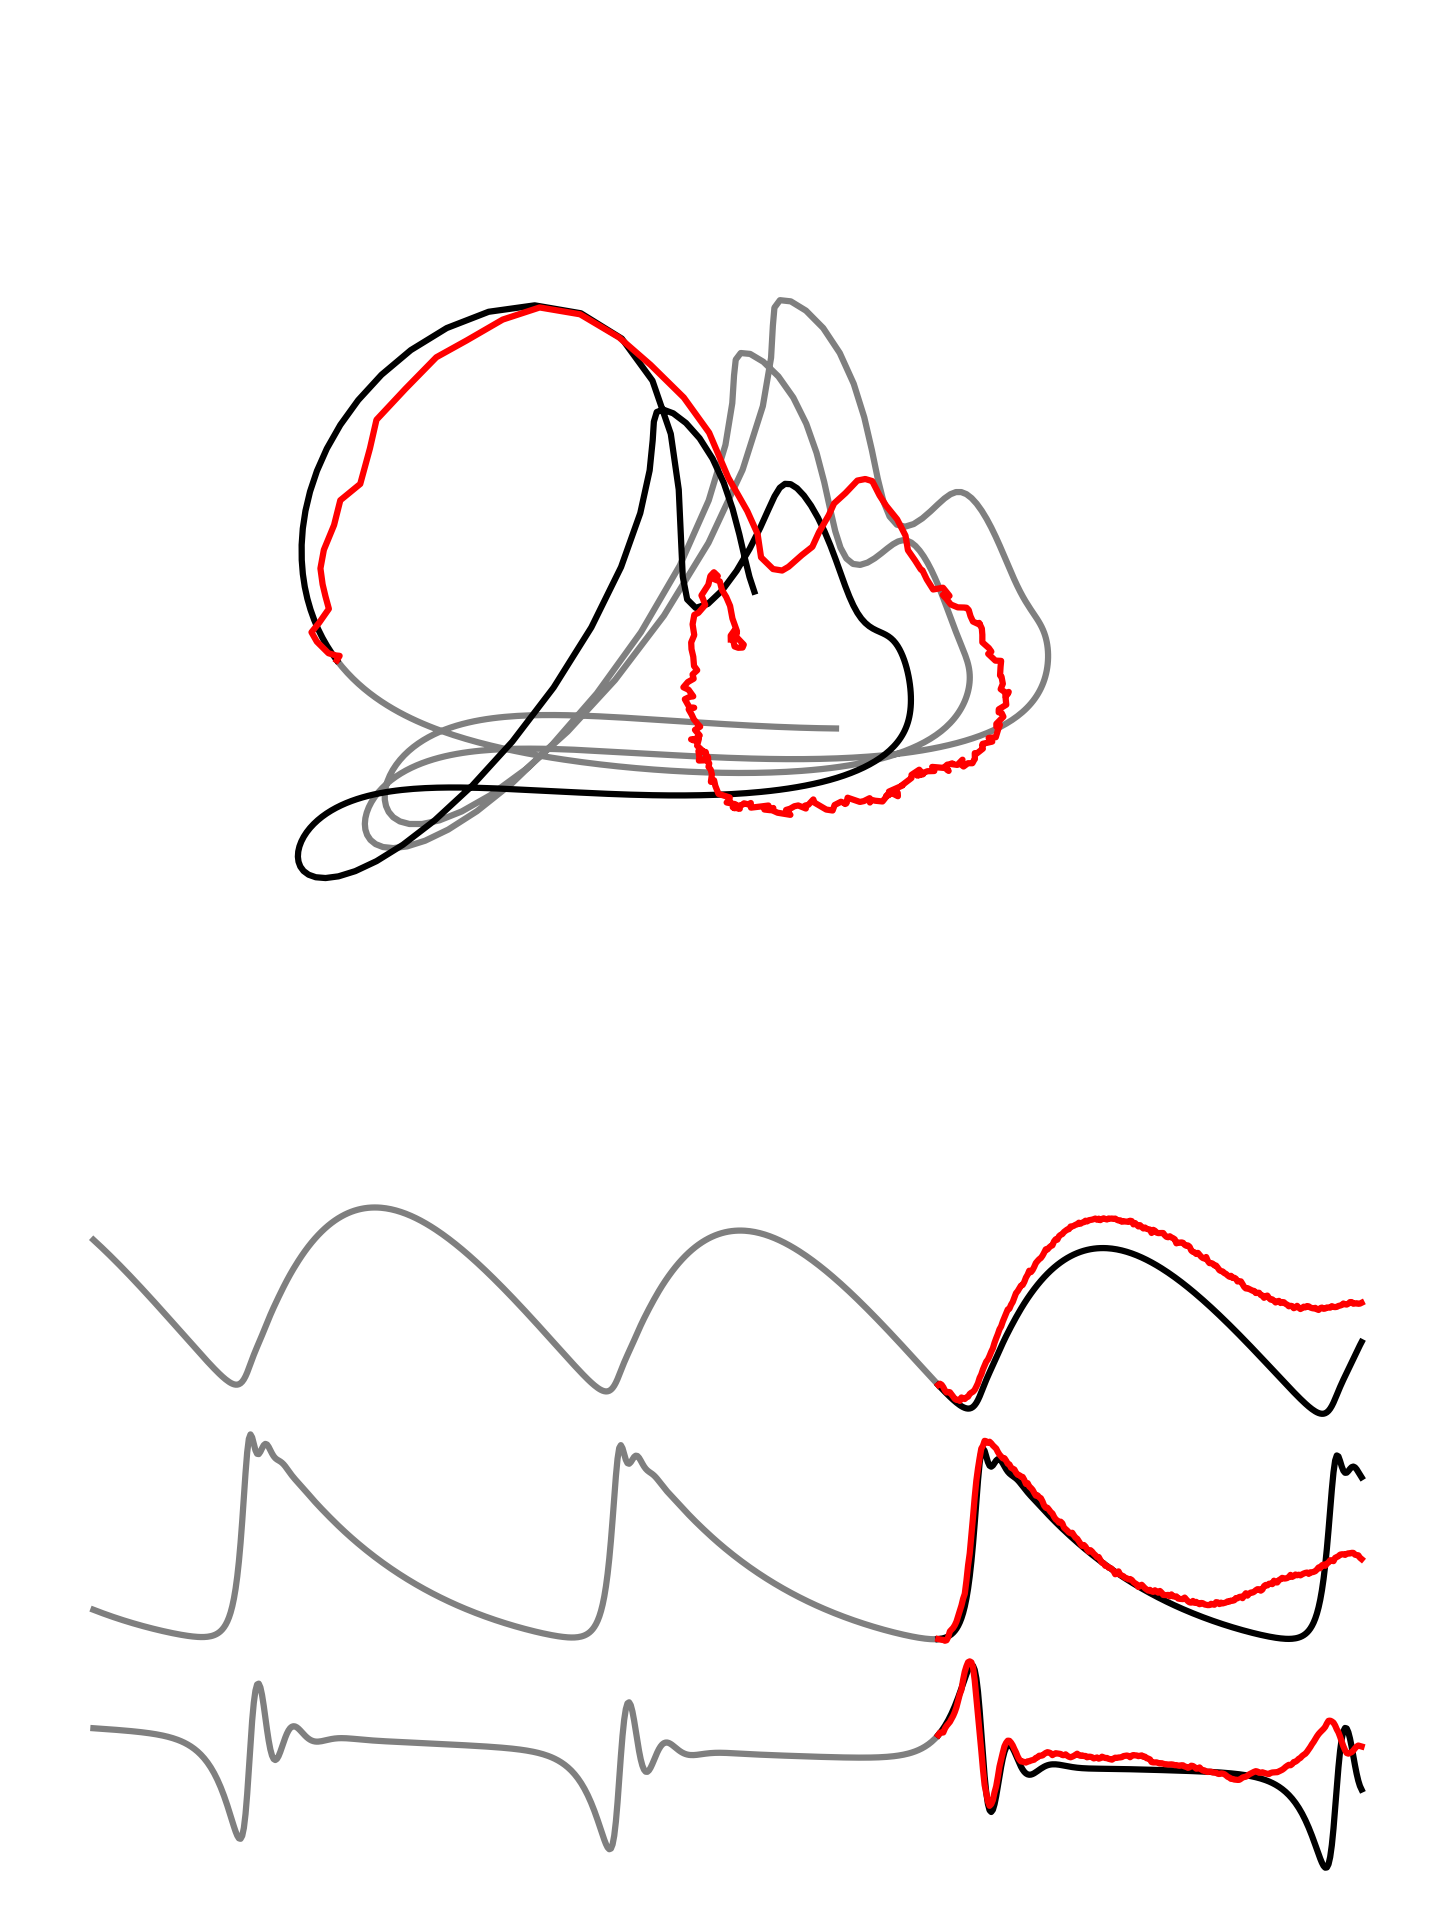

context_tensor shape: torch.Size([1, 512, 4])


/stor/home/ab75733/dystformer/panda/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


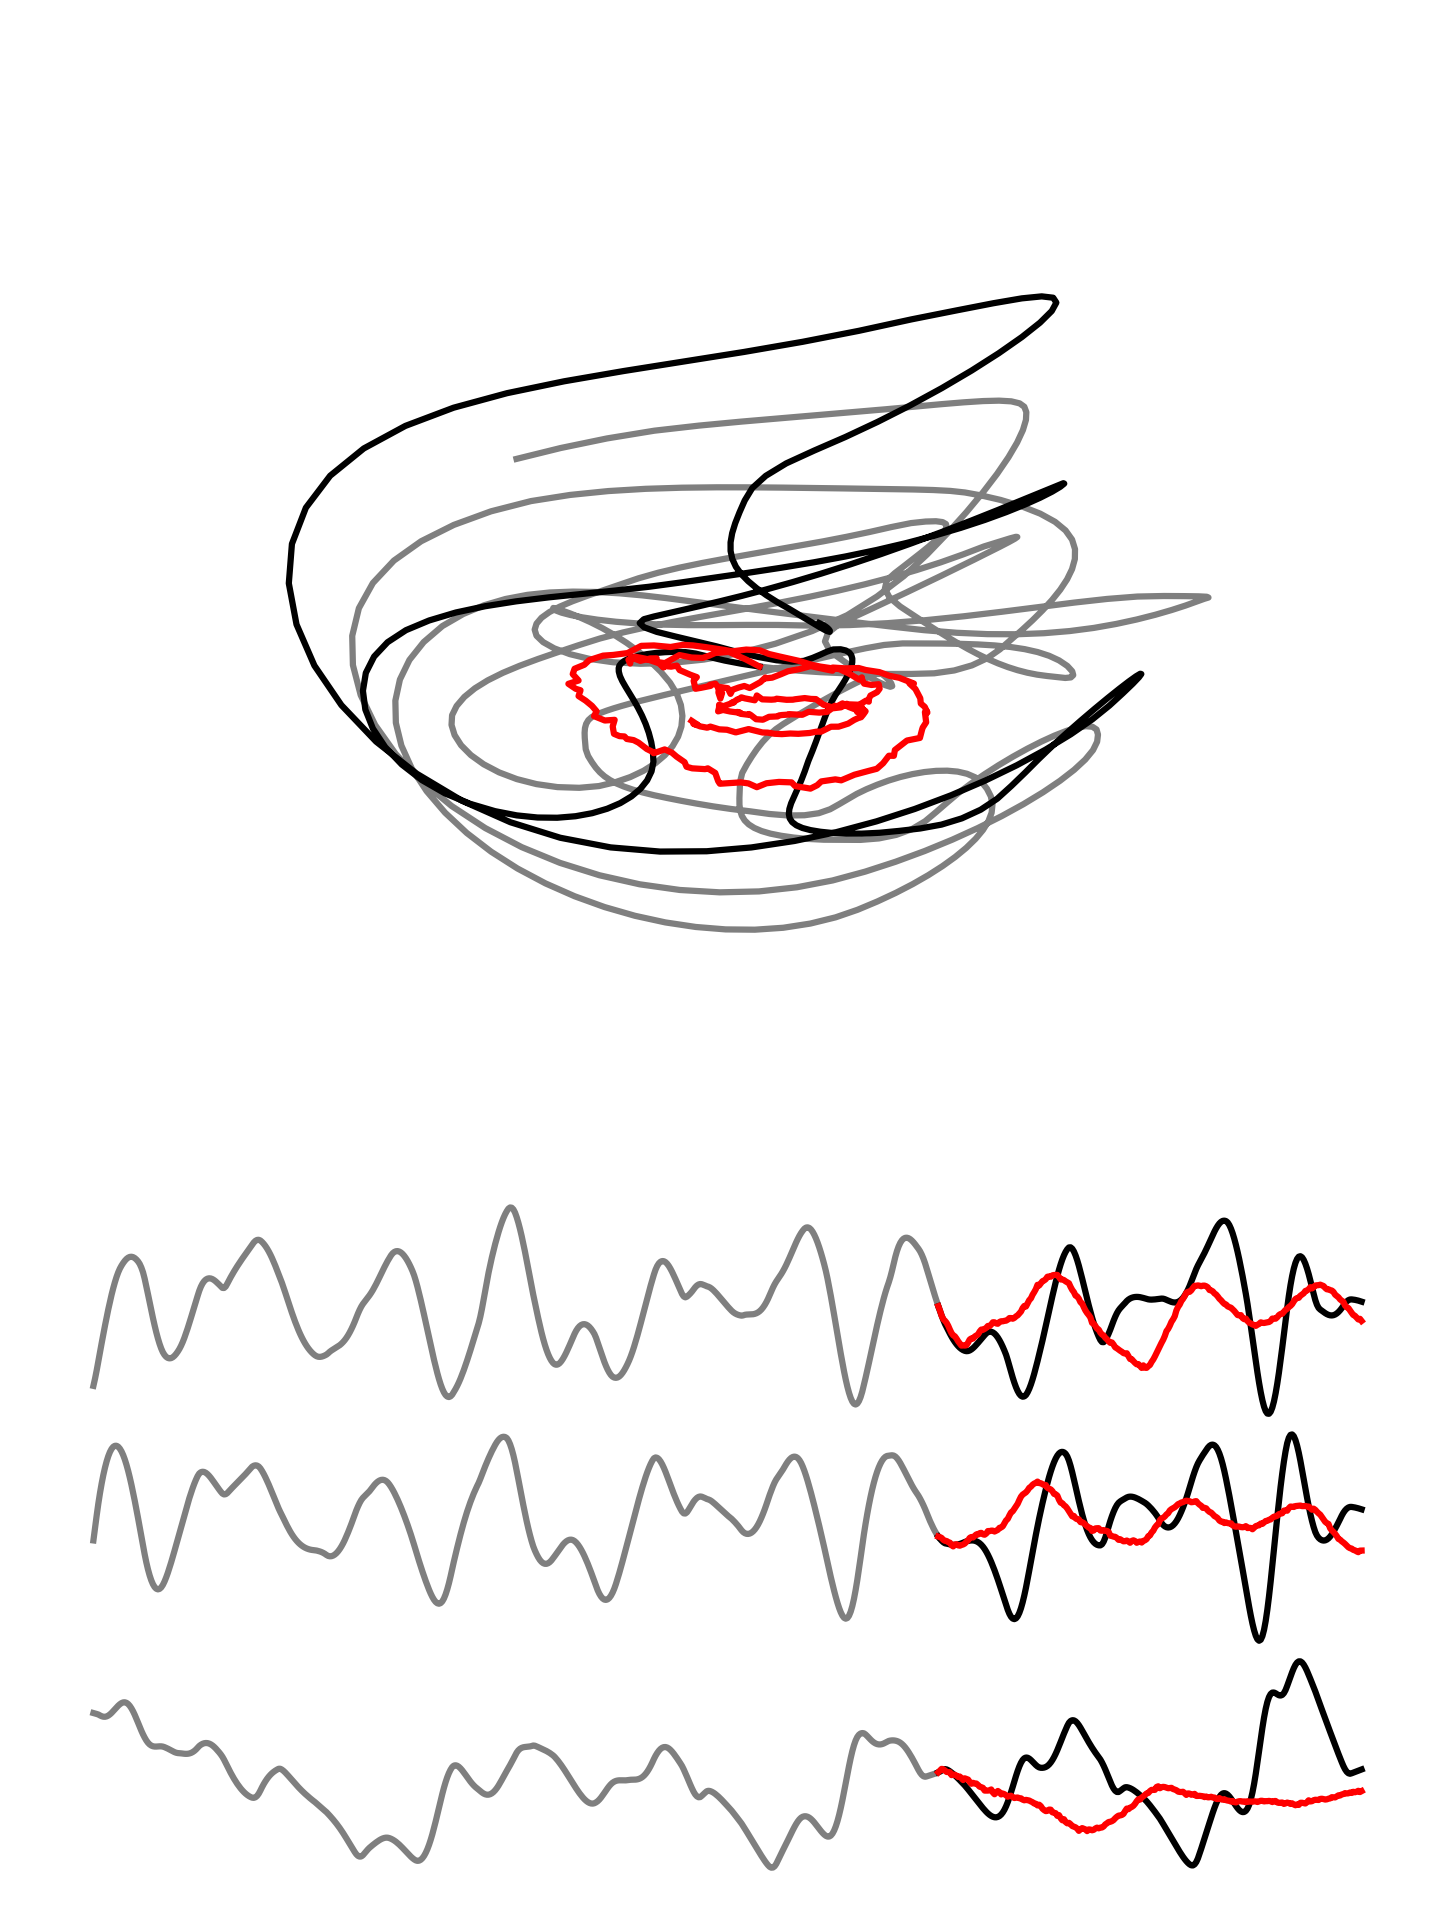

context_tensor shape: torch.Size([1, 512, 3])


/stor/home/ab75733/dystformer/panda/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


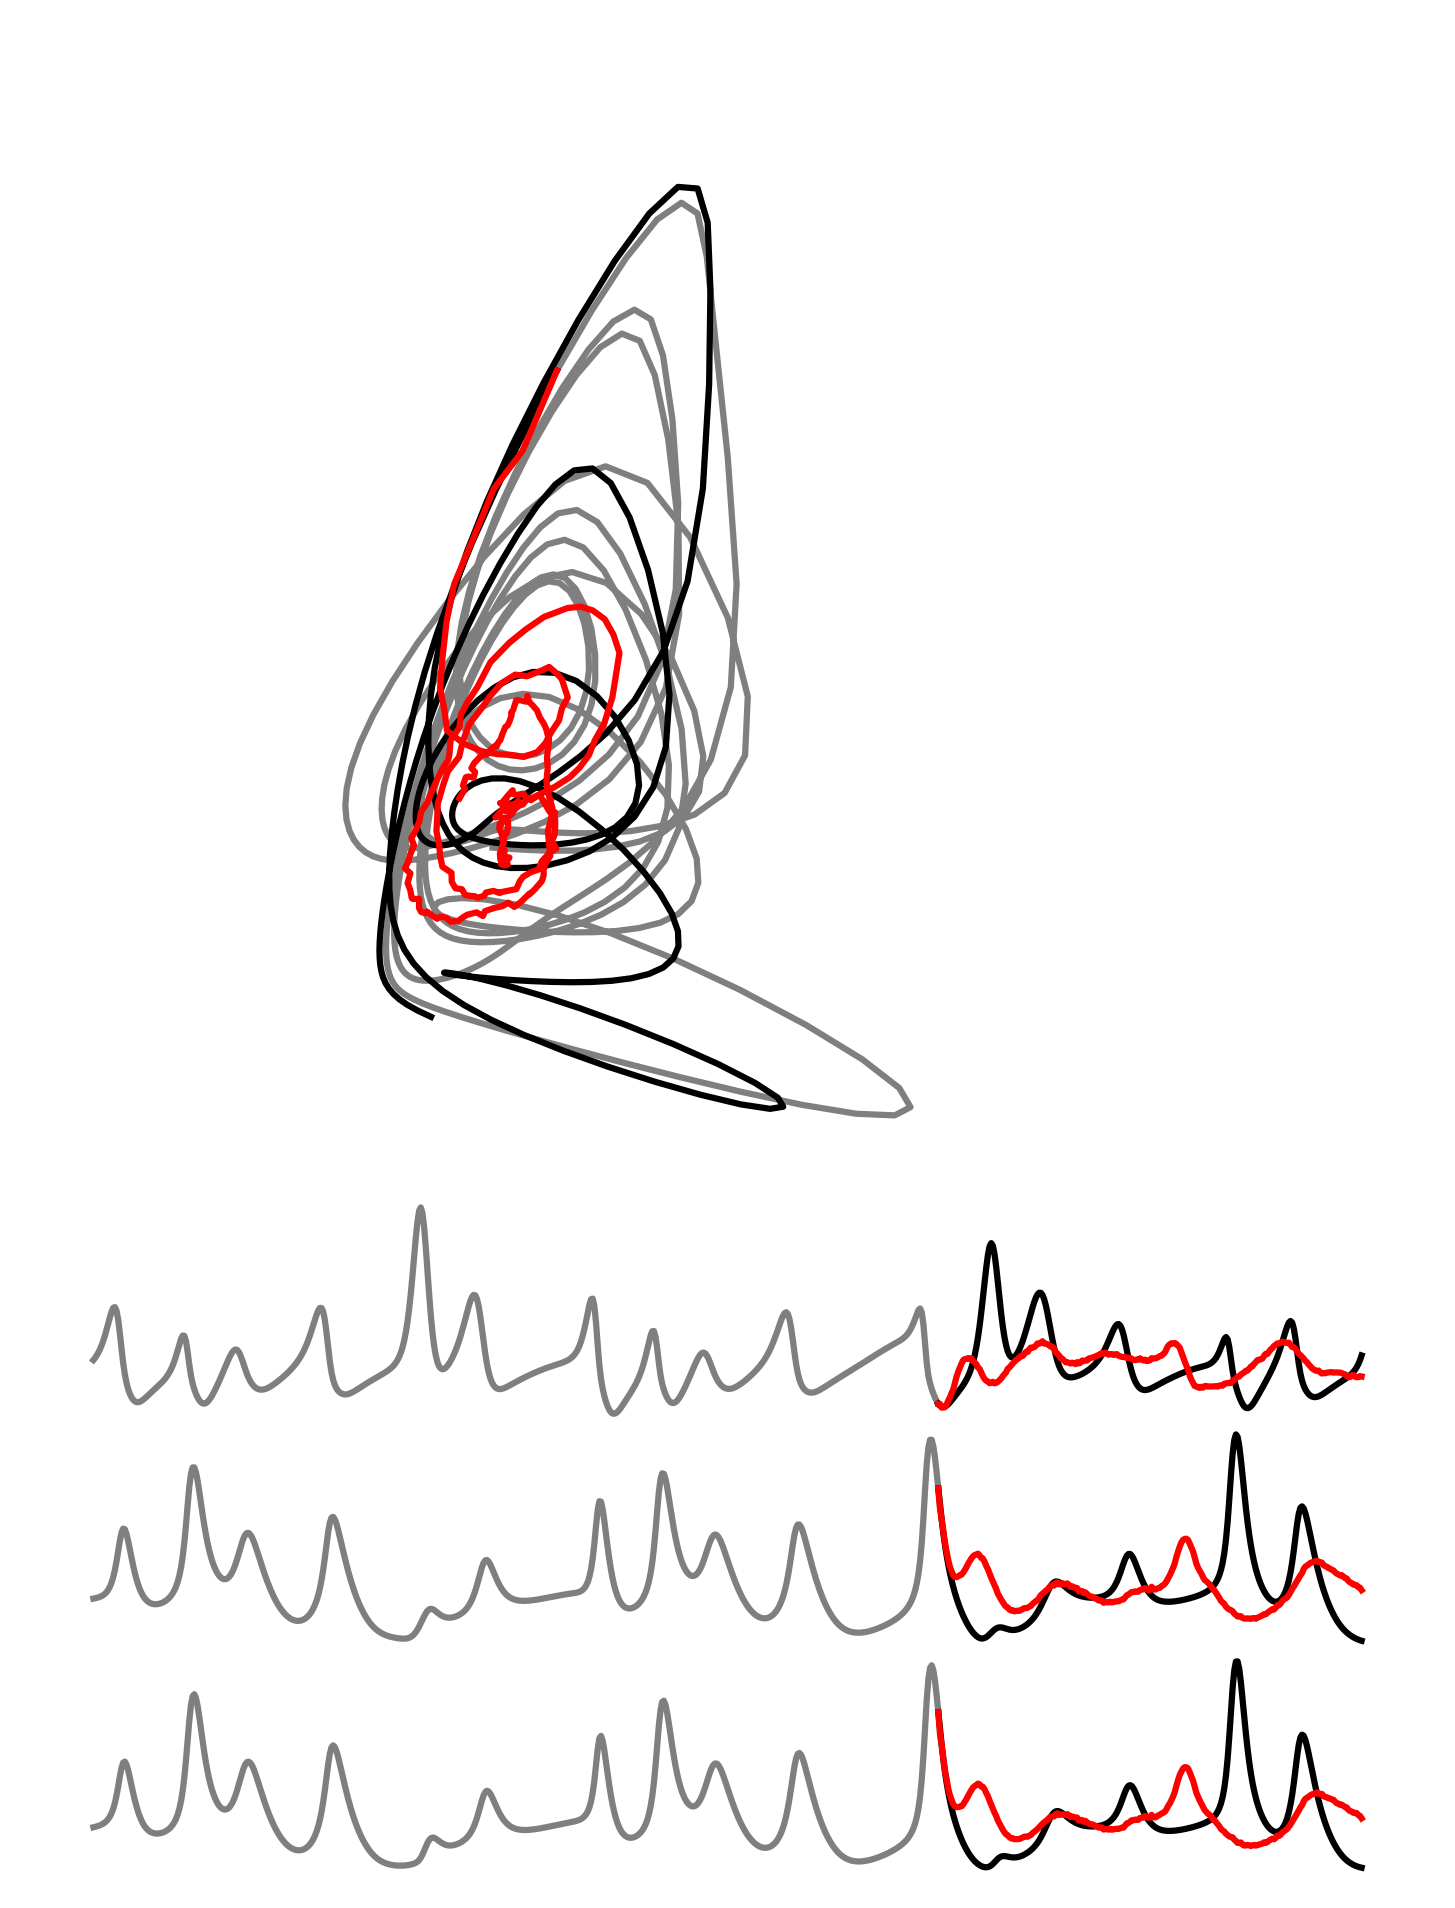

In [21]:
context_length = 512
save_forecasts = False

for dyst_name, settings in chosen_forecast_settings.items():
    sample_idx, start_time, pred_length, subsample_interval = settings

    syspaths = get_system_filepaths(dyst_name, test_data_dir, subsplit)
    trajectory, _ = load_trajectory_from_arrow(syspaths[sample_idx])
    trajectory = trajectory[:, ::subsample_interval]

    end_time = start_time + context_length

    save_path = os.path.join(
        "../figures",
        run_name,
        split,
        subsplit,
        f"{dyst_name}_sample{sample_idx}_context{start_time}-{end_time}_pred{pred_length}_.pdf",
    )

    plot_model_prediction(
        pft_model,
        trajectory[:, start_time:end_time],  # context
        trajectory[:, end_time : end_time + pred_length],  # ground truth
        pred_length,
        limit_prediction_length=False,
        sliding_context=True,
        save_path=save_path if save_forecasts else None,
        show_plot=True,
        figsize=(6, 8),
        # title=dyst_name,
    )